### Load libraries

In [1]:
# Basic libraries
import os, sys
from datetime import date
import pandas as pd 
import numpy as np 
import scanpy as sc 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# DGE analysis
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler 

# GO analysis
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import gseapy as gp
from gseapy.plot import gseaplot

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
# Container used for this analysis can be found here : cokorac/cs-core-image-amd64:dev
day = date.today()
print('The last use of the container:', day)

The last use of the container: 2025-06-22


### Load files

In [4]:
# Load the up-regulated DEGs
degs_up_hsNcx_vs_mmNcx_and_mmDG_vs_mmNcx = pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/intersected_degs/DEGs_up_hNcx_vs_mmDG_and_mm_DG_vs_mmNcx.csv")

In [5]:
# Load the background genes 
background_hsNcx_vs_mmDG = pd.DataFrame(pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_dg_rg_1/background_genes_hs_ncx_rg2_vs_mm_dg_rg_1.csv"))
background_hsNcx_vs_mmNcx = pd.DataFrame(pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/hs_ncx_rg2_vs_mm_ncx_rg/background_genes_hs_ncx_rg2_vs_mm_ncx_rg.csv"))
background_mmDG_vs_mmNcx = pd.DataFrame(pd.read_csv("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/degs/mm_dg_rg1_vs_mm_ncx_rg/background_genes_mm_dg_rg1_vs_mm_ncx_rg.csv"))

In [6]:
# Convert backgrounds to lists of genes 
background_list = []
for background in [background_hsNcx_vs_mmDG, background_hsNcx_vs_mmNcx, background_mmDG_vs_mmNcx]:
    background_list.append(background['Unnamed: 0'].tolist())

background_hsNcx_vs_mmDG, background_hsNcx_vs_mmNcx, background_mmDG_vs_mmNcx = background_list

In [7]:
# Intersect backgrounds 
intersected_bckgs = set(background_hsNcx_vs_mmDG).union(background_hsNcx_vs_mmNcx, background_mmDG_vs_mmNcx)
print(len(intersected_bckgs))

9918


### GO analysis

In [8]:
# Load the ontology lists
ontology_list = ['/group/kalebic/Nikola/1_single_cell_final/Chiara_final/scadd1ko/.cache/msigdb/c5.go.bp.v2023.2.Hs.symbols.gmt']

In [9]:
# GO for up_regulated in hsNcx_vs_mmDG_vs_mmNcx
up_hsNcx_vs_mmDG_vs_mmNcx = gp.enrichr(gene_list= degs_up_hsNcx_vs_mmNcx_and_mmDG_vs_mmNcx, 
                                       gene_sets= ontology_list, 
                                       organism='Human', 
                                       cutoff=0.5, 
                                       background = intersected_bckgs,
                                       no_plot= True)

up_hsNcx_vs_mmDG_vs_mmNcx_df = pd.DataFrame(up_hsNcx_vs_mmDG_vs_mmNcx.results)
# Save the GO results
up_hsNcx_vs_mmDG_vs_mmNcx_df.to_csv('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/results/GO/intersected_degs_GO/GO_hsNcx_vs_mmNcx_and_mmDG_vs_mmNcx_enrichment.csv')

In [10]:
# Define the 'Gene ontology type' 
up_hsNcx_vs_mmDG_vs_mmNcx_df['Ontology_type'] = up_hsNcx_vs_mmDG_vs_mmNcx_df.Gene_set.str[:8]

In [11]:
# Remove the insignificant terms
up_hsNcx_vs_mmDG_vs_mmNcx_df_sig = up_hsNcx_vs_mmDG_vs_mmNcx_df[up_hsNcx_vs_mmDG_vs_mmNcx_df['Adjusted P-value'] < 0.05]

In [12]:
# Sort based on the Combined Score
up_hsNcx_vs_mmDG_vs_mmNcx_df_sig = up_hsNcx_vs_mmDG_vs_mmNcx_df_sig.sort_values(by = 'Combined Score', ascending=False)

In [13]:
# Clean the 'Term' column 
up_hsNcx_vs_mmDG_vs_mmNcx_df_sig['Term_clean'] = up_hsNcx_vs_mmDG_vs_mmNcx_df_sig.Term.apply(lambda x: x[5:])
up_hsNcx_vs_mmDG_vs_mmNcx_df_sig["Term_clean"] = up_hsNcx_vs_mmDG_vs_mmNcx_df_sig["Term_clean"].str.replace("_", " ").str.capitalize()

In [14]:
# Subset the list of 'up-regulated' GO terms to terms of interest
# up-regulated terms (total : 78)
terms_of_interest_up = ['Extracellular matrix assembly', 'Amino acid transport', 'Sphingolipid biosynthetic process', 
                        'Gliogenesis', 'Neurogenesis', 'Cellular component morphogenesis', 'Lipid metabolic process', 
                        'Cell motility', 'Cell morphogenesis', 'Cell part morphogenesis']

up_hsNcx_vs_mmDG_vs_mmNcx_df_sig_ss = up_hsNcx_vs_mmDG_vs_mmNcx_df_sig[up_hsNcx_vs_mmDG_vs_mmNcx_df_sig['Term_clean'].isin(terms_of_interest_up)]

In [15]:
  # Sort values based on 'Modified Combined Score'
up_hsNcx_vs_mmDG_vs_mmNcx_df_sig_ss = up_hsNcx_vs_mmDG_vs_mmNcx_df_sig_ss.sort_values(by='Combined Score', ascending=False)

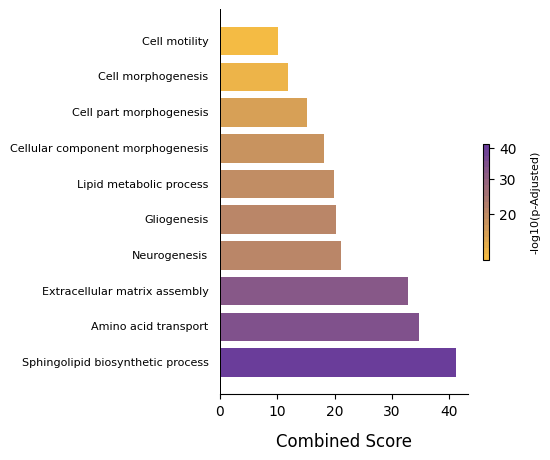

In [16]:
%run -i "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/helper_functions/GO_barplot.py"
# Plot
GO_barplot(up_hsNcx_vs_mmDG_vs_mmNcx_df_sig_ss)
# Save the plot
fig = plt.gcf()
fig.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/GO/intersected_degs_GO/GO_up_hsNcx_vs_mmNcx_and_mmDG_vs_mmNcx_barplot.pdf', dpi = 300, bbox_inches = 'tight')